# Transition from order to chaos

In [1]:
# -*- coding: utf-8 -*-
from __future__ import division, print_function, absolute_import

import numpy as np
import networkx as nx
import pandas as pd
import random
from scipy.spatial import distance


from reservoir_tools.utils import get_spectral_radius, nrmse, bisection, get_args_index, is_number
from reservoir_tools.control_graphs import control_graphs, randomize_network
from reservoir_tools.datasets import narma10, narma30
from reservoir_tools.tasks import memory_capacity, critical_memory_capacity
from reservoir_tools.readouts import LinearRegression, RidgeRegression
from reservoir_tools.reservoirs import simulate_reservoir_dynamics, remove_node, MLE
from reservoir_tools import grn_networks
from reservoir_tools import network_tools as nt
from reservoir_tools.network_statistics import average_degree, connectivity_fraction
from reservoir_tools.load_preserving_sign import load_preserving_signs

## Loading of the reservoir and scaling (input and spectral radius)

In [2]:
G=load_preserving_signs("reservoir_tools/red_simplificada.txt")
graph = nt.prune_graph(G, verbose=1)
a = nx.to_pandas_adjacency(graph)
arr = a.to_numpy()
adj_matrix = np.asarray(arr)
adj_matrix = adj_matrix.T

Deleted nodes: 3064 (23 roots, 3041 leaves)
Deleted nodes: 95 (2 roots, 93 leaves)
Deleted nodes: 14 (0 roots, 14 leaves)
Deleted nodes: 2 (0 roots, 2 leaves)
Deleted nodes: 1 (0 roots, 1 leaves)


In [4]:
random.seed(420)
np.random.seed(420)
prngI = np.random.RandomState(42)

size = graph.number_of_nodes() # 70
# INPUTS
num_inputs = float('0.66')
if num_inputs < 1:  # it cannot be the number of inputs
    num_inputs *= size  # so it must mean the proportion
num_inputs = int(num_inputs)
inputs_arr = np.sign(np.random.rand(size, 1) - 0.5) # -1, +1
inputs_arr[num_inputs:] = 0 # -1, +1, 0
rand_inputs = True
num_trials = 50

sample_len = 1000
nsamples = 10

In [5]:
array_SR_values = np.linspace(0.1, 1.9, 20)

all_experiments_mem_cap = []
all_experiments_lyap = []
a = 0
while a < num_trials:
    if rand_inputs:
        np.random.shuffle(inputs_arr)
    # generate dataset
    input_signal = [(prngI.rand(sample_len, 1)*2-1) for i in range(nsamples)]
    # reservoir adj. matrix
    weights = adj_matrix * np.random.uniform(0.0,1,size=adj_matrix.shape)
    # input
    in_scaling = 0.05
    in_weight = inputs_arr * in_scaling
     
    mem_capac_spectral = []
    lyapunovs = []
    for SR_scale in array_SR_values:
        # echo state property
        spectral_radius = get_spectral_radius(weights)
        weights *= SR_scale / spectral_radius

        # Run WT dynamics (for training)
        res_dynamics = [simulate_reservoir_dynamics(weights, in_weight.T,
                                                        i_sig.ravel())
                            for i_sig in input_signal]

        mem_capac_spectral.append(critical_memory_capacity(input_signal, res_dynamics))

        lyapunovs.append(MLE(res_dynamics[-1], weights, in_weight.T, input_signal[-1])) 

    all_experiments_mem_cap.append(mem_capac_spectral)
    all_experiments_lyap.append(lyapunovs)
    a+=1
    print(a)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


In [6]:
desviaciones_mem_cap = []
mean_mem_cap = []
for i in range(len(all_experiments_mem_cap[0])):
    results = []
    for experiment in all_experiments_mem_cap:
        results.append(experiment[i])
    desviaciones_mem_cap.append(np.std(results))
    mean_mem_cap.append(np.mean(results))

In [7]:
desviaciones_lyap = []
mean_lyap = []
for i in range(len(all_experiments_lyap[0])):
    results = []
    for experiment in all_experiments_lyap:
        results.append(experiment[i])
    desviaciones_lyap.append(np.std(results))
    mean_lyap.append(np.mean(results))

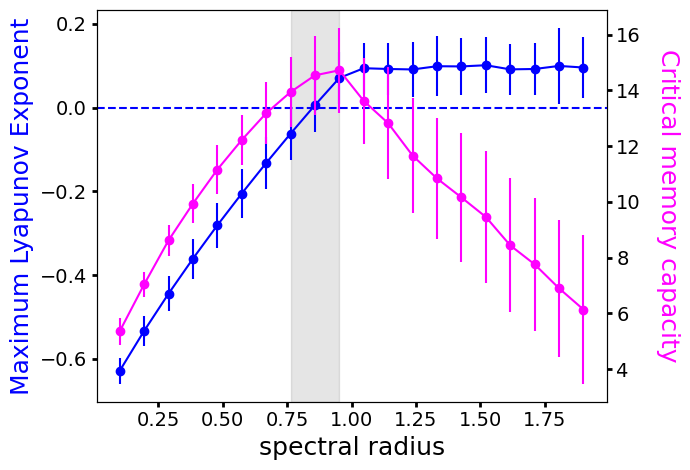

In [8]:
import matplotlib.pyplot as plt 
fig, ax1 = plt.subplots(figsize=(7.0, 4.8))

ax1.plot(array_SR_values , mean_lyap, "o",  color="blue")
ax1.errorbar(array_SR_values, mean_lyap, yerr=np.array(desviaciones_lyap), label='both limits (default)', color="blue")
ax1.axvspan(array_SR_values[int((np.abs(np.array(mean_lyap) - 0.0)).argmin())-1], array_SR_values[int((np.abs(np.array(mean_lyap) - 0.0)).argmin())+1], alpha=0.1, color='k')
ax1.axhline(y=0, ls="--", color = "blue")

ax1.set_xlabel('spectral radius', fontsize=18)
ax1.set_ylabel('Maximum Lyapunov Exponent', color="blue", fontsize=18)

ax2 = ax1.twinx()
ax2.plot(array_SR_values , mean_mem_cap, "o",  color="magenta")
ax2.errorbar(array_SR_values, mean_mem_cap, yerr=np.array(desviaciones_mem_cap), label='both limits (default)', color="magenta")

ax2.set_ylabel( "Critical memory capacity", color="magenta",alpha=1.0, fontsize=18, rotation=-90, labelpad=28)

#plt.title('High salt cultivated animals',fontweight="bold", fontsize=18, y=1.03)


ax2.tick_params(width=2, axis='both', which='major', labelsize=14)
ax1.tick_params(width=2, axis='both', which='major', labelsize=14)

plt.tight_layout()

plt.show()

In [ ]:
np.savetxt('Lyapunov_variedSR.txt', np.c_[array_SR_values, mean_lyap, desviaciones_lyap])   # x,y,z equal sized 1D arrays

In [ ]:
np.savetxt('Critical_mem_variedSR.txt', np.c_[array_SR_values, mean_mem_cap, desviaciones_mem_cap])   # x,y,z equal sized 1D arrays